In [1]:
import json

data = json.load(open('config.json', 'r', encoding='utf8'))

In [2]:
data.keys()

dict_keys(['completed', 'step_1', 'step_2', 'step_3'])

In [3]:
import pandas as pd

In [4]:
df_arr = pd.DataFrame({
    'date': data['step_2']['xs'],
    'n_arr': data['step_2']['ys']
})
df_arr

,date,n_arr
0,2024-10-01,2.116019
1,2024-10-02,2.116029
2,2024-10-03,2.116042
3,2024-10-04,2.116061
4,2024-10-05,2.116089
...,...,...
146,2025-02-24,2.116000
147,2025-02-25,2.116000
148,2025-02-26,2.116000
149,2025-02-27,2.116000


In [5]:
df_arr.date[0]

'2024-10-01'

In [6]:
df_arr.date = pd.to_datetime(df_arr.date)
df_arr.date[:10]

0   2024-10-01
1   2024-10-02
2   2024-10-03
3   2024-10-04
4   2024-10-05
5   2024-10-06
6   2024-10-07
7   2024-10-08
8   2024-10-09
9   2024-10-10
Name: date, dtype: datetime64[ns]

<Axes: xlabel='date'>

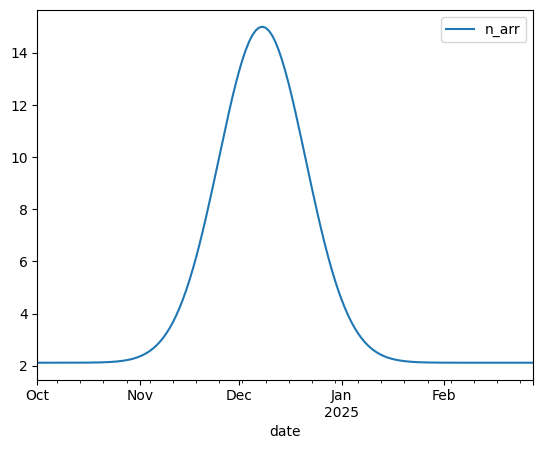

In [7]:
df_arr.plot(x='date', y='n_arr')

In [8]:
from scipy import stats

In [9]:
n = data['step_3']['selected_dists']['paeds']
params = data['step_3']['dists']['paeds'][n]

dist_paeds = getattr(stats, n)(**params)

print(dist_paeds.dist.name)
dist_paeds.kwds

genhyperbolic


{'p': -0.3023685348444624,
 'a': 2.237863755025021,
 'b': 2.2194479387233113,
 'loc': 0.3100321434414689,
 'scale': 0.37992439044793436}

In [10]:
n = data['step_3']['selected_dists']['adult']
params = data['step_3']['dists']['adult'][n]

dist_adult = getattr(stats, n)(**params)

print(dist_adult.dist.name)
dist_adult.kwds

genhyperbolic


{'p': -0.031781317536850616,
 'a': 3.405172001096986,
 'b': 3.389108415988021,
 'loc': 0.12084849786926694,
 'scale': 0.47536291525568297}

In [11]:
n = data['step_3']['selected_dists']['senior']
params = data['step_3']['dists']['senior'][n]

dist_senior = getattr(stats, n)(**params)

print(dist_senior.dist.name)
dist_senior.kwds

genexpon


{'a': 0.09966757968288487,
 'b': 0.2229084323738606,
 'c': 4.693407483531251,
 'loc': 0.003021774062861417,
 'scale': 4.034911780519071}

In [12]:
age_dist = data['step_3']['age_dist']
age_dist

{'paeds': 0.049954586739327886,
 'adult': 0.3042688465031789,
 'senior': 0.6457765667574932}

In [13]:
import salabim as sim

In [14]:
# Get the simulation end, i.e. midnight one day after the last day in `df_arr`
sim_end = list(df_arr.date)[-1] + pd.Timedelta(days=1)

In [15]:
from math import isnan
from numpy.random import normal

u01 = sim.Uniform(0, 1)
JITTER = 0.05 # Add 5% jitter to simulation arrivals


class Environment(sim.Environment):
    """The simulation environment"""
    beds: sim.Resource

    # Use virtual resources as counters for different types of bed occupancies
    beds_adult: sim.Resource
    beds_paeds: sim.Resource

    def setup(self):
        self.beds = sim.Resource('beds', capacity=sim.inf, env=self)
        self.beds_adult = sim.Resource('beds', capacity=sim.inf, env=self)
        self.beds_paeds = sim.Resource('beds', capacity=sim.inf, env=self)


class Patient(sim.Component):
    """A patient in the respiratory disease model."""

    def process(self):
        """Model a patient journey through the ward."""
        self.env: Environment

        # Arrivals are generated at midnight but released to the system at a random time of day
        self.hold(self.env.days(u01))

        is_paeds = False
        if (r := u01()) < age_dist['paeds']:
            is_paeds = True
            los = dist_paeds.rvs()
        elif r < age_dist['paeds'] + age_dist['adult']:
            los = dist_adult.rvs()
        else:
            los = dist_senior.rvs()
        
        assert not isnan(los), 'LOS is nan'
        los = max(0, los)  # Clip to bounds

        self.request(self.env.beds)  # 1 hold
        self.request(self.env.beds_paeds if is_paeds else self.env.beds_adult)  # 2 holds
        self.hold(los)
        self.release(self.env.beds_paeds if is_paeds else self.env.beds_adult)  # 1 holds
        self.release(self.env.beds)  # 0 holds


class DailyArrivals(sim.Component):
    """Daily Arrival generator."""

    def process(self):
        """Generate patients. Patients are batch-generated each day; each Patient instance
        is responsible for entering the system at the correct time-of-day using
        `Patient.hold()`."""
        for n_cases in df_arr.n_arr:
            n = round(n_cases * normal(1.0, JITTER))
            for _ in range(n):
                Patient()
            self.hold(self.env.days(1.0))


def simulate(df_arr: pd.DataFrame, until: pd.Timestamp):
    """The respirator disease model simulation."""
    env = Environment(time_unit='days', datetime0=df_arr.date[0], random_seed='*')
    DailyArrivals(env=env)

    env.run(env.datetime_to_t(until))

    beds_df = env.beds.claimed_quantity.as_dataframe().set_index('t')
    beds_paeds_df = env.beds_paeds.claimed_quantity.as_dataframe().set_index('t')
    beds_adult_df = env.beds_adult.claimed_quantity.as_dataframe().set_index('t')

    beds_df.index = beds_df.index.map(env.t_to_datetime)
    beds_paeds_df.index = beds_paeds_df.index.map(env.t_to_datetime)
    beds_adult_df.index = beds_adult_df.index.map(env.t_to_datetime)

    beds_df = beds_df.resample('1D').max().ffill()
    beds_paeds_df = beds_paeds_df.resample('1D').max().ffill()
    beds_adult_df = beds_adult_df.resample('1D').max().ffill()

    return {
        'total': beds_df, 'paeds': beds_paeds_df, 'adult': beds_adult_df
    }

In [16]:
dfs = []
dfs_adult = []
dfs_paeds = []

for _ in range(30):
    result = simulate(df_arr, until=sim_end)
    dfs.append(result['total'])
    dfs_paeds.append(result['paeds'])
    dfs_adult.append(result['adult'])

df30 = pd.concat(dfs, axis=1)
df30_adult = pd.concat(dfs_adult, axis=1)
df30_paeds = pd.concat(dfs_paeds, axis=1)

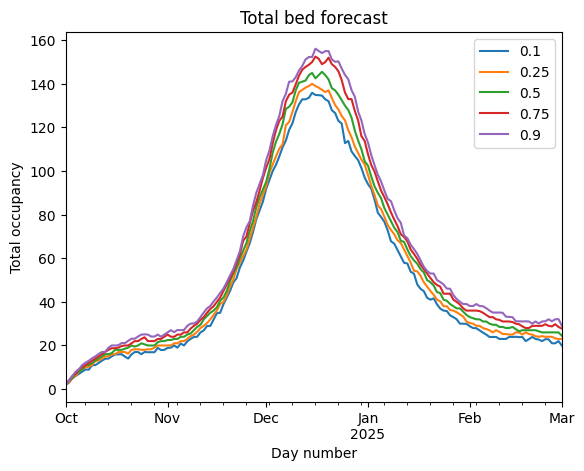

In [17]:
from matplotlib import pyplot as plt

quantiles = df30.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9], axis=1).T
quantiles.plot(xlabel='Day number', ylabel='Total occupancy', title='Total bed forecast')
plt.show()

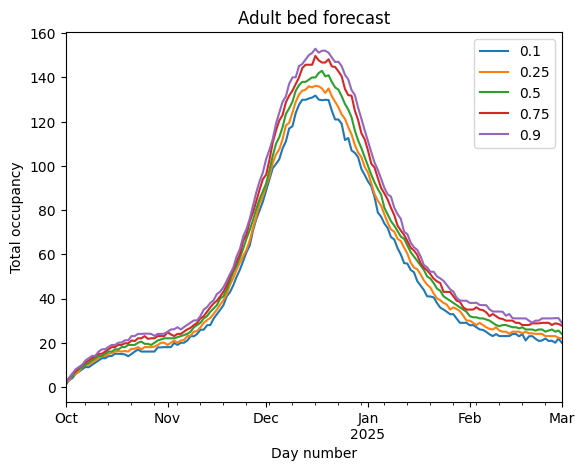

In [18]:
quantiles = df30_adult.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9], axis=1).T
quantiles.plot(xlabel='Day number', ylabel='Total occupancy', title='Adult bed forecast')
plt.show()

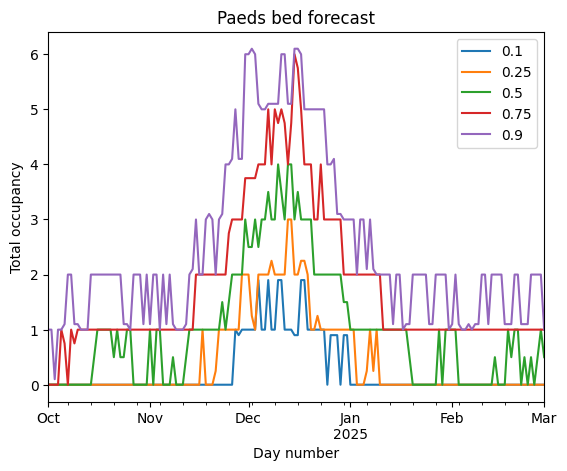

In [19]:
quantiles = df30_paeds.quantile(q=[0.1, 0.25, 0.5, 0.75, 0.9], axis=1).T
quantiles.plot(xlabel='Day number', ylabel='Total occupancy', title='Paeds bed forecast')
plt.show()